In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats
import pickle

# Data Pre-Processing

In [2]:
def cleanup(data):
    """
    Clean up CSV file output from Prolific experiment. 
    """
    fields = data.strip().split(',')
    fields = [field.strip('"').replace('\\', '').replace('{', '').replace('}', '').replace("'", '').replace("[", '').replace("]", '').replace('"', '') for field in fields]
    return fields

In [3]:
def parseCSV(filepath):
    """
    Parse rawdata CSV file saved from Prolific experiment. 
    """
    processed_data = []

    with open(filepath, 'r', encoding='utf-8') as file:
        for i,subj_data in enumerate(file):

            if i==0: continue # CSV headers

            processed_subj = cleanup(subj_data)

            subject_info = {
                'worker': processed_subj[0],
                'assignment': processed_subj[1],
                'hit': processed_subj[2],
                'version': processed_subj[3],
                'timestamp': processed_subj[4]
                }

            img_responses = []
            post_survey = {}
            resp = None

            for item in processed_subj[5:]:
                if ':' in item:
                    key, value = item.split(':', 1)

                    if key == 'response':
                        resp = value
                    elif key == 'image_name':
                        subject_info[os.path.basename(value)] = resp
                    else:
                        post_survey[key] = value

                # If subjects include newline character in post-survey comments
                else:
                    value = item
                    if resp and resp in post_survey:
                        post_survey[last_key] += ' ' + value

            subject_info.update(post_survey)
            processed_data.append(subject_info)

        # Create a DataFrame
        df = pd.DataFrame(processed_data)
        return df

In [4]:
def filter_subjects(df, attentioncheck):
    """
    Filter out subjects from the DataFrame based on the attention check. 
    Also filters out test runs of the experiment (labeled 'TEST' in post-survey comments). 
    If attentioncheck is true, filter based on attention check; otherwise, just remove test runs. 
    """

    df['agents'] = pd.to_numeric(df['agents'], errors='coerce')
    df['plates'] = pd.to_numeric(df['plates'], errors='coerce')
    if attentioncheck:
        filtered_df = df[(df['agents'] == 3) & (df['plates'] == 3) & (~df['comments'].str.contains("TEST", na=False))]
    else:
        filtered_df = df[(~df['comments'].str.contains("TEST", na=False))]
    return filtered_df

In [5]:
filepath = '../rawdata/socloaf_expt1.csv'
df = parseCSV(filepath)
filtered_df = filter_subjects(df, attentioncheck=True)

In [6]:
filtered_df

,worker,assignment,hit,version,timestamp,dishescartoon_4_1.png,dishescartoon_2_8.png,dishescartoon_2_1.png,carrotcartoon_4_4.png,carrotcartoon_6_8.png,...,agents,plates,language,enjoyment,assess,age,gender_cat,gender_text,education,comments
0,552bf9b4fdf99b59afb6c38c,65b3fb7367894cbe1ea79433,65b400ba27bd3a2352ec4501,2023-12-06_socloaf_pilot,1706296164923,4,3,3,4,4,...,3,3,English,average,y,49,f,,college,I looked at the number of guests.
1,5576a928fdf99b31db3db316,65b40475ed12840abf5fbfe4,65b4134ba1e10c16d02e8b9c,2023-12-06_socloaf_pilot,1706300719449,4,3,5,3,6,...,3,3,English,average,y,42,f,,some-college,Nothing specificn
2,5588b9e5fdf99b7f40e7f428,65b40475ed12840abf5fbfe4,65b4147a107250aade5a0e1d,2023-12-06_socloaf_pilot,1706301160484,6,2,3,5,5,...,3,3,English,average,y,49,m,,high,just looked at the amount of work versus how m...
3,5599dbe6fdf99b4a3c5bc628,65b3f5269833c155e17c68ca,65b3f80c1d3d2d78403ec682,2023-12-06_socloaf_pilot,1706293904819,10,2,9,10,9,...,3,3,English,average,y,39,f,,high,Looked at the number of guests and plates
4,559c3e04fdf99b32b55f2d8a,65b3fb7367894cbe1ea79433,65b4005f8bb35f4190cae255,2023-12-06_socloaf_pilot,1706295667058,8,7,8,10,10,...,3,3,English,average,y,40,f,,college,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,65b270b706be42a7b7590c1c,65b52b9d15649e564a9ca153,65b52d9488f68f98cf53b920,2023-12-06_socloaf_pilot,1706372679856,NaN,NaN,7,NaN,NaN,...,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,65b2fff4b9cd4d02c2d0bdbd,65b40475ed12840abf5fbfe4,65b414677b83b82de0a01a8b,2023-12-06_socloaf_pilot,1706300881632,1,2,1,3,3,...,3,3,English,average,confused,22,f,,college,
297,65b3e8ba80c47eba28c1eb4c,65b3f5269833c155e17c68ca,65b3f741e8ce6cff21fb31f8,2023-12-06_socloaf_pilot,1706293520037,10,3,7,5,7,...,3,3,english,average,y,35,f,,some-college,It did not specify whether or not the red gues...
298,65b3e9c8dab764979c0e7fc9,65b3ede04e33fd6b635a03c5,65b3f0ca107250aade5a0511,2023-12-06_socloaf_pilot,1706291786946,5,1,2,5,7,...,3,3,English,better,y,62,f,,grad,The more people at the table less likely red n...


# Building & fitting the mixed linear model

In [8]:
def effect_code_workload(image_name):
    if '_1.png' in image_name:
        return [1, 0]
    elif '_4.png' in image_name:
        return [0, 0]
    elif '_8.png' in image_name:
        return [0, 1]
    else:
        return [None, None]

def effect_code_groupsize(image_name):
    if 'cartoon_2' in image_name:
        return [1, 0]
    elif 'cartoon_4' in image_name:
        return [0, 0]
    elif 'cartoon_6' in image_name:
        return [0, 1]
    else:
        return [None, None]

In [9]:
image_columns = [col for col in filtered_df.columns if col.endswith('.png')]

long_df = pd.melt(filtered_df, id_vars=['worker'], value_vars=image_columns, var_name='image', value_name='resp')
long_df[['x_1_1', 'x_1_2']] = pd.DataFrame(long_df['image'].apply(effect_code_workload).tolist(), index=long_df.index)
long_df[['x_2_1', 'x_2_2']] = pd.DataFrame(long_df['image'].apply(effect_code_groupsize).tolist(), index=long_df.index)

long_df = long_df.dropna(subset=['x_1_1', 'x_1_2', 'x_2_1', 'x_2_2'])
long_df['response'] = pd.to_numeric(long_df['resp'], errors='coerce')
long_df = long_df.dropna(subset=['response'])

model = smf.mixedlm("response ~ x_1_1 + x_1_2 + x_2_1 + x_2_2 + x_1_1:x_2_1 + x_1_1:x_2_2 + x_1_2:x_2_1 + x_1_2:x_2_2", long_df, groups=long_df["worker"])
result = model.fit()

print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: response   
No. Observations: 5125    Method:             REML       
No. Groups:       286     Scale:              3.2918     
Min. group size:  3       Log-Likelihood:     -10749.9760
Max. group size:  18      Converged:          Yes        
Mean group size:  17.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       5.522    0.130 42.407 0.000  5.267  5.777
x_1_1           0.997    0.108  9.267 0.000  0.786  1.208
x_1_2          -0.311    0.108 -2.888 0.004 -0.522 -0.100
x_2_1          -1.012    0.108 -9.406 0.000 -1.223 -0.801
x_2_2           0.572    0.108  5.317 0.000  0.361  0.782
x_1_1:x_2_1     0.118    0.152  0.775 0.439 -0.180  0.416
x_1_1:x_2_2    -0.246    0.152 -1.614 0.106 -0.544  0.053
x_1_2:x_2_1    -0.121   

# Visualizing subject responses

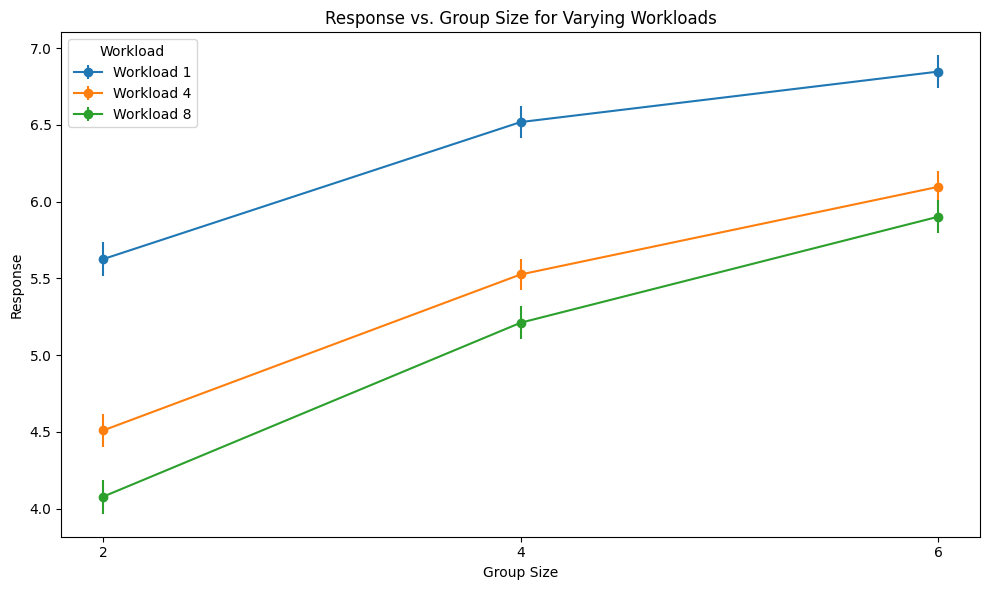

In [11]:
def standard_error(data):
    return scipy.stats.sem(data)

groupcoding = [
    (long_df['x_2_1'] == 1) & (long_df['x_2_2'] == 0), 
    (long_df['x_2_1'] == 0) & (long_df['x_2_2'] == 0), 
    (long_df['x_2_1'] == 0) & (long_df['x_2_2'] == 1) 
]

long_df['Group Size'] = np.select(groupcoding, [2,4,6], default=np.nan)

low_workload_data = long_df[long_df['x_1_1'] == 1]
med_workload_data = long_df[(long_df['x_1_1'] == 0) & (long_df['x_1_2'] == 0)]
high_workload_data = long_df[long_df['x_1_2'] == 1]

plt.figure(figsize=(10, 6))

# Plotting each workload with standard error
for data, label in zip([low_workload_data, med_workload_data, high_workload_data], ['Workload 1', 'Workload 4', 'Workload 8']):
    means = data.groupby('Group Size')['response'].mean()
    sems = data.groupby('Group Size')['response'].apply(standard_error)
    plt.errorbar(means.index, means, yerr=sems, label=label, fmt='-o')  # fmt specifies the line style and marker

plt.xlabel('Group Size')
plt.ylabel('Response')
plt.title('Response vs. Group Size for Varying Workloads')
plt.legend(title='Workload')
plt.xticks([2,4,6])
plt.tight_layout()
plt.show()